## Rubric Guideline for  HW 

Rubric for each HW question: 
* Downloaded the data correctly [5points]
* Good EDA (Exploratory data analysis) [5points]
* Metrics defined for success  [5points]
* Use of pipelines [5 points]
* Data prep (split into train, and test)  [10 points]
  * fill in missing data
  * standardizing the data
  * categorical pipeline
  * numerical pipeline
* Machine learning pipeline (for a baseline) [5 points]
* Experimental results table shown  [5 points]
* Bonus points 
  * statistical significance tests a baseline versus challenger [for 5 bonus points]


# Task: MNIST Handwritten Digit classification

_Task: train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?_

** NOTE** The solution is partially filled in. But you will need to fill in the missing parts and run all cells, report results and your conclusions.

So lets train  on a dataset of handwritten numbers, with labels to tell us what the numbers should be. MNIST has 60,000 training examples, and 10,000 for testing.

First, let's load the dataset and split it into a training set and a test set. We could use `train_test_split()` but people usually just take the first 60,000 instances for the training set, and the last 10,000 instances for the test set (this makes it possible to compare your model's performance with others): 

## Download MNSIT Data
this might take a minute to download..retry if if fails


In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
#mnist = fetch_mldata('mnist-original', data_home='d:\\')
X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [2]:
y_train

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first:

In [3]:
import numpy as np
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

## Train a linear SVM classifier

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

In [4]:
from sklearn.svm import LinearSVC
#might take a minute or two to train
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Let's make predictions on the training set and measure the accuracy (we don't want to measure it on the test set yet, since we have not selected and trained the final model yet):

In [5]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.85375000000000001

Wow, 82% accuracy on MNIST is a really bad performance. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

## Standardize the data and put in a pipeline

Standardize the data and put in a pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [7]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [8]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train,y_pred)

0.9204

## Use non-linear kernels (RBFs, Polynomial?)

Put everything in a **pipeline**.

That's much better (we cut the error rate in two), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Warning**: if you are using Scikit-Learn ≤ 0.19, the `SVC` class will use the One-vs-One (OvO) strategy by default, so you must explicitly set `decision_function_shape="ovr"` if you want to use the OvR strategy instead (OvR is the default since 0.19).

In [9]:
from sklearn.svm import SVC
svm_clf = SVC(decision_function_shape="ovr")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.94615000000000005

## Tune hyperparameters

Put everything in a **pipeline**.

That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])  #### use a subset of the data to speed things up

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=79.5231605842, gamma=0.00176607465048 .........................
[CV] .......... C=79.5231605842, gamma=0.00176607465048, total=   0.5s
[CV] C=79.5231605842, gamma=0.00176607465048 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .......... C=79.5231605842, gamma=0.00176607465048, total=   0.5s
[CV] C=79.5231605842, gamma=0.00176607465048 .........................
[CV] .......... C=79.5231605842, gamma=0.00176607465048, total=   0.5s
[CV] C=2.07005900705, gamma=0.00184893979432 .........................
[CV] .......... C=2.07005900705, gamma=0.00184893979432, total=   0.5s
[CV] C=2.07005900705, gamma=0.00184893979432 .........................
[CV] .......... C=2.07005900705, gamma=0.00184893979432, total=   0.5s
[CV] C=2.07005900705, gamma=0.00184893979432 .........................
[CV] .......... C=2.07005900705, gamma=0.00184893979432, total=   0.5s
[CV] C=89.8773818971, gamma=0.0408025396137 ..........................
[CV] ........... C=89.8773818971, gamma=0.0408025396137, total=   0.7s
[CV] C=89.8773818971, gamma=0.0408025396137 ..........................
[CV] ........... C=89.8773818971, gamma=0.0408025396137, total=   0.7s
[CV] C=89.8773818971, gamma=0.0408025396137 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.6s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4DA85A208>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4DA85A710>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [12]:
rnd_search_cv.best_estimator_

SVC(C=79.523160584230865, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
rnd_search_cv.best_score_

0.85599999999999998

This looks pretty low but remember we only trained the model on 1,000 instances. Let's retrain the best estimator on the whole training set (run this at night, it will take hours):

In [14]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=79.523160584230865, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

Ah, this looks good! Let's select this model. Now we can test it on the test set:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing `C` and/or `gamma`), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

# Task: Regression

Using the California housing dataset train and tune up an SVM regressor pipeline. Is your best SVR pipeline statistically significantly better than randomforests?

For information on the see [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)

* This dataset consists of 20,640 samples and 9 features.


** NOTE** The solution is partially filled in. But you will need to fill in the missing parts and run all cells, report results and your conclusions.


## Download data and do EDA

Let's load the dataset using Scikit-Learn's `fetch_california_housing()` function:

In [39]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(data_home='/Users/rohan.kayan/scikit_learn_data')
X = housing["data"]
y = housing["target"]

In [40]:
housing.DESCR

'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n'

In [41]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

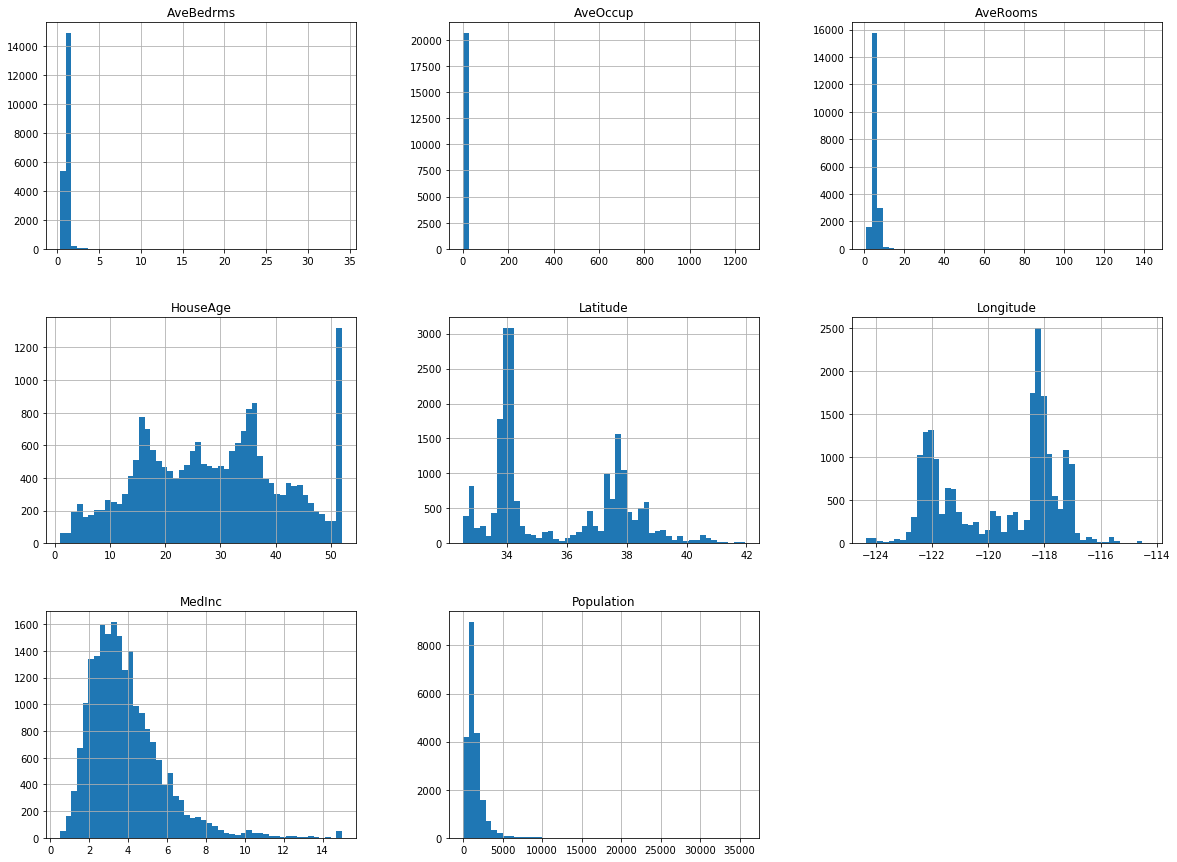

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df=pd.DataFrame(X, columns=housing.feature_names)
df.hist(bins=50, figsize=(20,15))
plt.show()

In this training set, the targets are hundreds of thousands of dollars. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F48022E2B0>]], dtype=object)

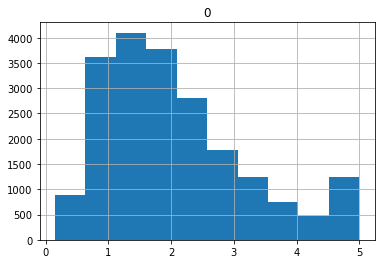

In [43]:
# Plot Target variable
# Target variable has been scaled by $100,000
pd.DataFrame(y).hist()

Split it into a training set and a test set:

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build a baseline pipeline

Don't forget to scale the data and use pipeline. Add pipelines here.

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple `LinearSVR` first:

In [46]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

Let's see how it performs on the training set:

In [47]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.96128066532972722

Let's look at the RMSE:

In [48]:
import numpy as np
np.sqrt(mse)

0.98044921608909819

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $100,000. Not great. 

## Tune hyperparameters of SVR
Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [49]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=38.4540118847, gamma=0.0796945481864 ..........................
[CV] ........... C=38.4540118847, gamma=0.0796945481864, total=  13.6s
[CV] C=38.4540118847, gamma=0.0796945481864 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


[CV] ........... C=38.4540118847, gamma=0.0796945481864, total=  13.5s
[CV] C=38.4540118847, gamma=0.0796945481864 ..........................
[CV] ........... C=38.4540118847, gamma=0.0796945481864, total=  14.1s
[CV] C=74.1993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=74.1993941811, gamma=0.0157513204998, total=  10.3s
[CV] C=74.1993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=74.1993941811, gamma=0.0157513204998, total=  10.1s
[CV] C=74.1993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=74.1993941811, gamma=0.0157513204998, total=   9.9s
[CV] C=16.6018640442, gamma=0.00205111041884 .........................
[CV] .......... C=16.6018640442, gamma=0.00205111041884, total=   5.4s
[CV] C=16.6018640442, gamma=0.00205111041884 .........................
[CV] .......... C=16.6018640442, gamma=0.00205111041884, total=   5.3s
[CV] C=16.6018640442, gamma=0.00205111041884 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F480269BA8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F480264EB8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [50]:
rnd_search_cv.best_estimator_

SVR(C=38.454011884736246, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.079694548186439285, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Now let's measure the RMSE on the training set:

In [51]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5446663900096772

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [59]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rnd_search_rmse = np.sqrt(mse)

## TASK: Contrast with a random forest with 100 decision trees with a depth of 10.

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform, randint

param_distributions = {"n_estimators": randint(low=1,high=200), "max_features": randint(low=1, high=8)}

#rnd_search_cv = RandomizedSearchCV(RandomForestRegressor(), param_distributions, n_iter=10, verbose=2, random_state=42)
#rnd_search_cv.fit(X_train_scaled, y_train)

rfr = RandomForestRegressor(n_estimators=100,max_depth=10)
rfr.fit(X_train_scaled, y_train)

#Random Forest Regressor 
y_pred = rfr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse_rfr = np.sqrt(mse)

In [54]:
rmse_rfr


0.54443164839561609

In [56]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=10)
dtr.fit(X_train_scaled, y_train)


y_pred = dtr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse_dtr = np.sqrt(mse)

In [60]:
print("Root mean Squared error for Random Forest Regressor:",rmse_rfr)
print("Root mean Squared error for Decision Tree Regressor:",rmse_dtr)
print("Root mean Squared error for Random Search with SVR :",rnd_search_rmse)


Root mean Squared error for Random Forest Regressor: 0.544431648396
Root mean Squared error for Decision Tree Regressor: 0.645885901674
Root mean Squared error for Random Search with SVR : 0.570463714768


## Random Forest Regrssor is giving better results.  

# [Optional Task] Extend Linear SVM classifier via BGD to multiple classes

Extend the following implementation of a Linear SVM classifier via batch gradient descent to case there deals with 3 or more   classes.

**NOTE** Adopt all the code and experiments in this section and modify as needed to classify the 3-class iris dataset on 2=dimensional input space (petal length, petal width).

Please see lecture (video and slides for details of the multiple class training SVM algorithm) and read the next subsection `SVM Multiclass Loss function` to get more background. 

Please implement the ** vectorized version**  of multiclass Linear SVM.


## SVM Multiclass Loss function
Quality of weights is often expressed by a loss function, our unhappiness with classification result, and we want its value to be as small as possible. To minimize the loss, we have to define a loss function and find their partial derivatives with respect to the weights to update them iteratively.

$$\begin{equation}
L_i = \sum_{j\neq y_i} \left[ \max(0, x_iw_j - x_iw_{y_i} + \Delta) \right] \tag{1}
\end{equation} 
$$

Where 


* $i$ iterates over all N examples,
* $j$ iterates over all C classes,
* $L_i$ is loss for classifying a single example  $x_i$ (row vector),
* $w_j$ is the weights (column vector) for computing the score of class j,
* $y_i$ is the index of the correct class of $x_i$, and
* $Δ$ is a margin parameter which is commonly set to $1$

Intuitively, SVM wants score, $x_iw_{y_i}$, of the correct class, $y_i$, to be greater than any other classes, $x_iw_j$, by at least $Δ$ such that the loss becomes zero (clamped with the max operation).

### Analytic gradient
The gradient of the loss function for a **single example**, $(\vec{X_i}, y_i)$ can be written in full detail as:

$$\nabla_{w} L_i 
  =
  \begin{bmatrix}
    \frac{dL_i}{dw_1} & \frac{dL_i}{dw_2} & \cdots & \frac{dL_i}{dw_C} 
  \end{bmatrix}
  = 
  \begin{bmatrix}
    \frac{dL_i}{dw_{11}} & \frac{dL_i}{dw_{21}} & \cdots & \frac{dL_i}{dw_{y_i1}} & \cdots & \frac{dL_i}{dw_{C1}} \\
    \vdots & \ddots \\
    \frac{dL_i}{dw_{1D}} & \frac{dL_i}{dw_{2D}} & \cdots & \frac{dL_i}{dw_{y_iD}} & \cdots & \frac{dL_i}{dw_{CD}} 
  \end{bmatrix}\tag{2}
  $$
  
  First, let’s find a sub-gradient $ \frac{dL_i}{dw_{11}}$ (one element from equation (2) by considering all the terms in equation (1) (the SVM loss for one example $i$ with respect to all classes):
  
 
\begin{align*}
L_i = &\max(0, x_{i1}w_{11} + x_{i2}w_{12} \ldots + x_{iD}w_{1D} - x_{i1}w_{y_i1} - x_{i2}w_{y_i2} \ldots - x_{iD}w_{y_iD} + \Delta) + \\
 &\max(0, x_{i1}w_{21} + x_{i2}w_{22} \ldots + x_{iD}w_{2D} - x_{i1}w_{y_i1} - x_{i2}w_{y_i2} \ldots - x_{iD}w_{y_iD} + \Delta) + \\
&\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \\
&\max(0, x_{i1}w_{C1} + x_{i2}w_{C2} \ldots + x_{iD}w_{CD} - x_{i1}w_{y_i1} - x_{i2}w_{y_i2} \ldots - x_{iD}w_{y_iD} + \Delta) \tag{3}
\end{align*} 

For a general case, if $ (x_iw_1−x_iw_{y_i}+Δ)>0 $:

$$\frac{dL_i}{dw_{11}}=x_{i1} $$


Looking closely at this equation: 

* $w_{11}$ corresponds to first weight in the weigth vector that is normal to the separtating hyperplance for  class 1 and 
* all terms in equation (3) that do not involve $w_{11}$ go to zero (think of them as a constant being  differentiated)

Hence, we consider two cases:

* $w_j$ for class weights of  the not class
* $w_{y_i}$ for class weights of the  class 


#### Case 1: $w_j$ for class weights of  the not class
\begin{align*}
\frac{dL_i}{dw_{j}} &= \mathbb{1}(x_iw_j - x_iw_{y_i} + \Delta > 0)
  \begin{bmatrix}
  x_{i1} \\
  x_{i2} \\
  \vdots \\
  x_{iD}
  \end{bmatrix}
\\
&= \mathbb{1}(x_iw_j - x_iw_{y_i} + \Delta > 0) x_i \tag{4}
\end{align*}



Equivalently, using an indicator function of the form $1(.)$:

$$ \dfrac{dL_i}{dw_{11}} = 1(x_iw_1−x_iw_{y_i}+Δ>0)   = x_{i1} $$


#### Case 1:$w_{y_i}$ for class weights of  the not class
For a special case where $j=y_i$,


$$
\frac{dL_i}{dw_{y_{i1}}} = -(\ldots) x_{i1}
$$


The coefficent of $x_{i1}$ is the number of classes that meet the desire margin. Mathematically speaking, $\sum_{j\neq y_i} \mathbb{1}(x_iw_j - x_iw_{y_i} + \Delta > 0)$. Hence,



\begin{align*}
\frac{dL_i}{dw_{y_i}} &= - \sum_{j\neq y_i} \mathbb{1}(x_iw_j - x_iw_{y_i} + \Delta > 0)
  \begin{bmatrix}
  x_{i1} \\
  x_{i2} \\
  \vdots \\
  x_{iD}
  \end{bmatrix}
\\
&= - \sum_{j\neq y_i} \mathbb{1}(x_iw_j - x_iw_{y_i} + \Delta > 0) x_i \tag{5}
\end{align*}


<p>Equipped with equations (1)-(5), we have enough information to implement a loss function and gradient update for a multiclass SVM.</p>

<p>The IPython Notebook <a href="http://vision.stanford.edu/teaching/cs231n/winter1516_assignment1.zip">svm.ipynb</a> from <a href="http://vision.stanford.edu/teaching/cs231n/syllabus.html">Stanford CS231n</a> is a great starting point to understand implementation of the SVM classifier. The exercise asks us to implement both non-vectorized and vectorized versions of loss function and gradient update.</p>

### non-vectorized-implementation

Looking at the terms in equation (1) suggests us to compute scores of all classes with $x_iW$, given an example $x_i$. The loss function can be implemented with two for-loops. The inner loop collects loss of all classes of a single example and the outer loop collects it across all examples. 


We compute analytic gradient 
$\nabla_{w} L_i 
  =
  \begin{bmatrix}
    \frac{dL_i}{dw_1} & \frac{dL_i}{dw_2} & \cdots & \frac{dL_i}{dw_C} 
  \end{bmatrix}
$  one element at a time in the inner loop. 


Considering equation (4) (CASE 1), we compute the gradient w.r.t. weights of class j with `dW[:,j] += X[i,:]`. Note that we use `+=` here as we have to collect the gradient across all classes j and across all examples. Considering equation (5)  (CASE 2), we compute the gradient of class $y_i$ with `dW[:,y[i]] -= X[i,:]`. Unlike the previous case, this single class $y_i$ requires us to count the number of classes that satisfy the margin condition; hence, the use of `-=`.



In [32]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero
  
  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in xrange(num_train):
    scores = X[i,:].dot(W)
    correct_class_score = scores[y[i]]
    for j in xrange(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 
      if margin > 0:
        loss += margin
        dW[:,y[i]] -= X[i,:] 
        dW[:,j] += X[i,:] 

  # Averaging over all examples
  loss /= num_train
  dW /= num_train

  # Add regularization
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg*W
  
  return loss, dW

### Vectorized implementation (partial)
Instead of computing scores for each example, $x_iW$, we can compute them all at once with full matrix multiplication, $XW$. To compute the loss, this score matrix has to be subtracted row-wise by scores of correct classes and then added with Δ. Because the loss equation sums over all j except $y_i$, we have to set the yi component to zero. The trick to select correct-class scores across all examples is to use an array indexing technique together with NumPy’s arange. Please take this idea and implement the vectorized version of a multiclass SVM.


## Training set

In [33]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris.target


NameError: name 'datasets' is not defined

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

In [ ]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, n_iter = 50, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


## compare homegrown with LinearSVC and SVC 

_Exercise: train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        n_iter=100000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

Let's plot the decision boundaries of these three models:

In [ ]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Close enough!